https://github.com/kexinhuang12345/DeepPurpose


In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()


✨🍰✨ Everything looks OK!


In [2]:
!mamba install -c conda-forge -c rdkit rdkit notebook -y


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        Supported by @QuantStack

        GitHub:  https://github.com/QuantStack/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Getting  conda-forge linux-64
Getting  conda-forge noarch
Getting  rdkit linux-64
Getting  rdkit noarch
Getting  pkgs/main linu

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# !source activate DeepPurpose
!pip install scikit-learn numpy pandas
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/bp-kelley/descriptastorus 
!pip install DeepPurpose prody

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/bp-kelley/descriptastorus to /tmp/pip-req-build-nb43k25h
  Running command git clone -q https://github.com/bp-kelley/descriptastorus /tmp/pip-req-build-nb43k25h


In [5]:
!python -V


Python 3.7.10


In [6]:
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import pandas as pd
from DeepPurpose import DTI as models
from DeepPurpose.utils import *
from DeepPurpose.dataset import *


In [7]:
#!wget https://drive.google.com/file/d/1qnvNxd6SvhwHPxD0huTpmODB270ENs7j/view?usp=sharing -O data.tar.gz


In [8]:
import numpy as np
import random
import torch
from prody import parsePDB

def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    pass

In [9]:

from rdkit.Chem import AllChem

def smiles2canonical(smiles):
    m = AllChem.MolFromSmiles(smiles, sanitize=True)
    # m = AllChem.AddHs(m)
    # isomeric = AllChem.MolToSmiles(m, isomericSmiles=True)
    canonical = AllChem.MolToSmiles(m, isomericSmiles=False, canonical=True)
    return canonical

In [10]:
# Cell with constants
DATADIR = Path("data")
if not DATADIR.exists():
  # DATADIR.mkdir(DATADIR)
  !gdown --id 1qnvNxd6SvhwHPxD0huTpmODB270ENs7j
  !tar -xzvf inhibitors_data.tar.gz

RANDOM_SEED = 2407
seed_everything(RANDOM_SEED)
TMP_DIR = Path("tmp")
TMP_DIR.mkdir(exist_ok=True)

train_df = pd.read_csv(DATADIR / "train.csv", index_col=0)
test_df = pd.read_csv(DATADIR / "test.csv", index_col=0)

train_df['canonical'] = train_df.Smiles.apply(smiles2canonical)
test_df['canonical'] = test_df.Smiles.apply(smiles2canonical)

MODEL_NAME = 'Daylight_AAC_BindingDB'  # 'Morgan_AAC_BindingDB'
SMILES_COL = "canonical"  # "Smiles"
NFOLDS = 5

In [11]:
from torch.utils.data import DataLoader, SequentialSampler
import torch.nn as nn
import copy
from prettytable import PrettyTable
import DeepPurpose.utils as utils
from torch.utils.tensorboard import SummaryWriter
from time import time
from torch.autograd import Variable
import matplotlib.pyplot as plt

class ImbalancedDBTA(models.DBTA):
  def train(self, train, val = None, test = None, verbose = True):
      if len(train.Label.unique()) == 2:
          self.binary = True
          self.config['binary'] = True

      lr = self.config['LR']
      decay = self.config['decay']
      BATCH_SIZE = self.config['batch_size']
      train_epoch = self.config['train_epoch']
      if 'test_every_X_epoch' in self.config.keys():
          test_every_X_epoch = self.config['test_every_X_epoch']
      else:     
          test_every_X_epoch = 40
      loss_history = []

      self.model = self.model.to(self.device)

      # support multiple GPUs
      if torch.cuda.device_count() > 1:
          if verbose:
              print("Let's use " + str(torch.cuda.device_count()) + " GPUs!")
          self.model = nn.DataParallel(self.model, dim = 0)
      elif torch.cuda.device_count() == 1:
          if verbose:
              print("Let's use " + str(torch.cuda.device_count()) + " GPU!")
      else:
          if verbose:
              print("Let's use CPU/s!")
      # Future TODO: support multiple optimizers with parameters
      opt = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=decay)
      if verbose:
          print('--- Data Preparation ---')

      params = {
          'batch_size': BATCH_SIZE,
          'shuffle': True,
          'num_workers': self.config['num_workers'],
          'drop_last': False
      }
      if (self.drug_encoding == "MPNN"):
          params['collate_fn'] = utils.mpnn_collate_func
      elif self.drug_encoding in ['DGL_GCN', 'DGL_NeuralFP', 'DGL_GIN_AttrMasking', 'DGL_GIN_ContextPred', 'DGL_AttentiveFP']:
          params['collate_fn'] = utils.dgl_collate_func

      training_generator = DataLoader(utils.data_process_loader(train.index.values, train.Label.values, train, **self.config), **params)
      if val is not None:
          validation_generator = DataLoader(utils.data_process_loader(val.index.values, val.Label.values, val, **self.config), **params)
      
      if test is not None:
          info = data_process_loader(test.index.values, test.Label.values, test, **self.config)
          params_test = {
              'batch_size': BATCH_SIZE,
              'shuffle': False,
              'num_workers': self.config['num_workers'],
              'drop_last': False,
              'sampler': SequentialSampler(info)
          }
          if (self.drug_encoding == "MPNN"):
              params_test['collate_fn'] = utils.mpnn_collate_func
          elif self.drug_encoding in ['DGL_GCN', 'DGL_NeuralFP', 'DGL_GIN_AttrMasking', 'DGL_GIN_ContextPred', 'DGL_AttentiveFP']:
              params_test['collate_fn'] = utils.dgl_collate_func
          testing_generator = DataLoader(utils.data_process_loader(test.index.values, test.Label.values, test, **self.config), **params_test)
      # early stopping
      if self.binary:
          max_auc = 0
          max_auprc = 0
      else:
          max_MSE = 10000
      model_max = copy.deepcopy(self.model)

      valid_metric_record = []
      valid_metric_header = ["# epoch"] 
      if self.binary:
          valid_metric_header.extend(["AUROC", "AUPRC", "F1"])
      else:
          valid_metric_header.extend(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])
      table = PrettyTable(valid_metric_header)
      float2str = lambda x:'%0.4f'%x
      if verbose:
          print('--- Go for Training ---')
      writer = SummaryWriter()
      t_start = time() 
      iteration_loss = 0
      for epo in range(train_epoch):
          for i, (v_d, v_p, label) in enumerate(training_generator):
              if self.target_encoding == 'Transformer':
                  v_p = v_p
              else:
                  v_p = v_p.float().to(self.device) 
              if self.drug_encoding in ["MPNN", 'Transformer', 'DGL_GCN', 'DGL_NeuralFP', 'DGL_GIN_AttrMasking', 'DGL_GIN_ContextPred', 'DGL_AttentiveFP']:
                  v_d = v_d
              else:
                  v_d = v_d.float().to(self.device)                
                  #score = self.model(v_d, v_p.float().to(self.device))
                  
              score = self.model(v_d, v_p)
              label = Variable(torch.from_numpy(np.array(label)).float()).to(self.device)

              if self.binary:
                  loss_fct = torch.nn.BCELoss()
                  m = torch.nn.Sigmoid()
                  n = torch.squeeze(m(score), 1)
                  loss = loss_fct(n, label)
              else:
                  loss_fct = torch.nn.MSELoss()
                  n = torch.squeeze(score, 1)
                  loss = loss_fct(n, label)
              loss_history.append(loss.item())
              writer.add_scalar("Loss/train", loss.item(), iteration_loss)
              iteration_loss += 1

              opt.zero_grad()
              loss.backward()
              opt.step()

              if verbose:
                  if (i % 100 == 0):
                      t_now = time()
                      print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i) + \
                        ' with loss ' + str(loss.cpu().detach().numpy())[:7] +\
                        ". Total time " + str(int(t_now - t_start)/3600)[:7] + " hours") 
                      ### record total run time

          if val is not None:
              ##### validate, select the best model up to now 
              with torch.set_grad_enabled(False):
                  if self.binary:  
                      ## binary: ROC-AUC, PR-AUC, F1, cross-entropy loss
                      auc, auprc, f1, loss, logits = self.test_(validation_generator, self.model)
                      lst = ["epoch " + str(epo)] + list(map(float2str,[auc, auprc, f1]))
                      valid_metric_record.append(lst)
                      # if auc > max_auc:
                      if auprc > max_auprc:
                          model_max = copy.deepcopy(self.model)
                          max_auprc = auprc
                      if verbose:
                          print('Validation at Epoch '+ str(epo + 1) + ', AUROC: ' + str(auc)[:7] + \
                            ' , AUPRC: ' + str(auprc)[:7] + ' , F1: '+str(f1)[:7] + ' , Cross-entropy Loss: ' + \
                            str(loss)[:7])
                  else:  
                      ### regression: MSE, Pearson Correlation, with p-value, Concordance Index  
                      mse, r2, p_val, CI, logits, loss_val = self.test_(validation_generator, self.model)
                      lst = ["epoch " + str(epo)] + list(map(float2str,[mse, r2, p_val, CI]))
                      valid_metric_record.append(lst)
                      if mse < max_MSE:
                          model_max = copy.deepcopy(self.model)
                          max_MSE = mse
                      if verbose:
                          print('Validation at Epoch '+ str(epo + 1) + ' with loss:' + str(loss_val.item())[:7] +', MSE: ' + str(mse)[:7] + ' , Pearson Correlation: '\
                          + str(r2)[:7] + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI)[:7])
                          writer.add_scalar("valid/mse", mse, epo)
                          writer.add_scalar("valid/pearson_correlation", r2, epo)
                          writer.add_scalar("valid/concordance_index", CI, epo)
                          writer.add_scalar("Loss/valid", loss_val.item(), iteration_loss)
              table.add_row(lst)
          else:
              model_max = copy.deepcopy(self.model)

      # load early stopped model
      self.model = model_max

      if val is not None:
          #### after training 
          prettytable_file = os.path.join(self.result_folder, "valid_markdowntable.txt")
          with open(prettytable_file, 'w') as fp:
              fp.write(table.get_string())

      if test is not None:
          if verbose:
              print('--- Go for Testing ---')
          if self.binary:
              auc, auprc, f1, loss, logits = self.test_(testing_generator, model_max, test = True)
              test_table = PrettyTable(["AUROC", "AUPRC", "F1"])
              test_table.add_row(list(map(float2str, [auc, auprc, f1])))
              if verbose:
                  print('Validation at Epoch '+ str(epo + 1) + ' , AUROC: ' + str(auc)[:7] + \
                    ' , AUPRC: ' + str(auprc)[:7] + ' , F1: '+str(f1)[:7] + ' , Cross-entropy Loss: ' + \
                    str(loss)[:7])				
          else:
              mse, r2, p_val, CI, logits, loss_test = self.test_(testing_generator, model_max)
              test_table = PrettyTable(["MSE", "Pearson Correlation", "with p-value", "Concordance Index"])
              test_table.add_row(list(map(float2str, [mse, r2, p_val, CI])))
              if verbose:
                  print('Testing MSE: ' + str(mse) + ' , Pearson Correlation: ' + str(r2) 
                    + ' with p-value: ' + str(f"{p_val:.2E}") +' , Concordance Index: '+str(CI))
              np.save(os.path.join(self.result_folder, str(self.drug_encoding) + '_' + str(self.target_encoding) 
                    + '_logits.npy'), np.array(logits))                
      
          ######### learning record ###########

          ### 1. test results
          prettytable_file = os.path.join(self.result_folder, "test_markdowntable.txt")
          with open(prettytable_file, 'w') as fp:
              fp.write(test_table.get_string())

      ### 2. learning curve 
      fontsize = 16
      iter_num = list(range(1,len(loss_history)+1))
      plt.figure(3)
      plt.plot(iter_num, loss_history, "bo-")
      plt.xlabel("iteration", fontsize = fontsize)
      plt.ylabel("loss value", fontsize = fontsize)
      pkl_file = os.path.join(self.result_folder, "loss_curve_iter.pkl")
      with open(pkl_file, 'wb') as pck:
          pickle.dump(loss_history, pck)

      fig_file = os.path.join(self.result_folder, "loss_curve.png")
      plt.savefig(fig_file)
      if verbose:
          print('--- Training Finished ---')
          writer.flush()
          writer.close()
          


def model_pretrained(path_dir=None, model = None):
    if model is not None:
       path_dir = models.download_pretrained_model(model)
    config = models.load_dict(path_dir)
    model = ImbalancedDBTA(**config)
    model.load_pretrained(path_dir + '/model.pt')    
    return model

In [12]:

structure = parsePDB((DATADIR / 'target.pdb').as_posix(), debug=False)
#[x.name for x in structure.get_atoms() if not x.is_disordered()]
# [x.get_resname() for x in structure.get_residues()]
#structure.getSequence(), structure.getResnums(), [a for a in structure.iterAtoms()]
list(structure.iterChains())
calphas = structure.chain_A_and_calpha
sequence = calphas.getSequence()
sequence

@> 2874 atoms and 1 coordinate set(s) were parsed in 0.04s.
DEBUG:.prody:2874 atoms and 1 coordinate set(s) were parsed in 0.04s.


'EVNSFSGYLKLTDNVYIKNADIVEEAKKVKPTVVVNAANVYLKHGGGVAGALNKATNNAMQVESDDYIATNGPLKVGGSCVLSGHNLAKHCLHVVGPNVNKGEDIQLLKSAYENFNQHEVLLAPLLSAGIFGADPIHSLRVCVDTVRTNVYLAVFDKNLYDKLVSSFLE'

In [13]:
def balance_data(train_df, target_col="Label"):
    df = train_df[target_col].value_counts()
    m = df.max()
    new_index = []
    for i, c in df.reset_index().values:
        ids = train_df[target_col]==i
        values = train_df[ids].index
        if c == m:
            new_index.extend(values)
        else:
            new_index.extend(np.random.choice(values, m))
    np.random.shuffle(new_index)
    return train_df.loc[new_index]



Drug Target Interaction Prediction Mode...
in total: 5557 drug-target pairs
encoding drug...
unique drugs: 5396
rdkit not found this smiles: [I-].[K+] convert to all 0 features
encoding protein...
unique target sequence: 1
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
do not do train/test split on the data for already splitted data
Dataset already downloaded in the local system...
Let's use 1 GPU!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 2.96702. Total time 0.00027 hours
Validation at Epoch 1, AUROC: 0.49944 , AUPRC: 0.03746 , F1: 0.07407 , Cross-entropy Loss: 11.6477
Training at Epoch 2 iteration 0 with loss 0.64825. Total time 0.00166 hours
Validation at Epoch 2, AUROC: 0.62592 , AUPRC: 0.08318 , F1: 0.10989 , Cross-entropy Loss: 5.03182
Training at Epoch 3 iteration 0 with loss 0.28504. Total tim

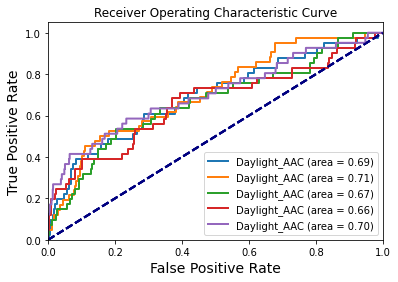

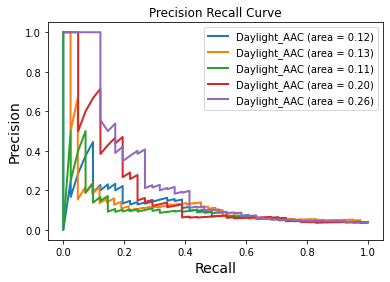

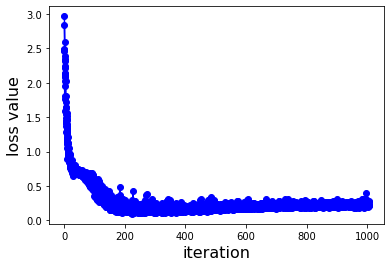

In [14]:
from sklearn.model_selection import StratifiedKFold
# Load Data, an array of SMILES for drug, an array of Amino Acid Sequence for Target and an array of binding values/0-1 label.
# e.g. ['Cc1ccc(CNS(=O)(=O)c2ccc(s2)S(N)(=O)=O)cc1', ...], ['MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTH...', ...], [0.46, 0.49, ...]
# In this example, BindingDB with Kd binding score is used.
# X_drug, X_target, y  = process_BindingDB(download_BindingDB(SAVE_PATH),
# 					 y = 'Kd', 
# 					 binary = False, 
# 					 convert_to_log = True)


X_drug = list(train_df[SMILES_COL].values)
X_target = [sequence] *train_df.shape[0]
y = train_df.Active.values*1
# Type in the encoding names for drug/protein.
drug_encoding, target_encoding = 'Daylight', 'AAC'

# Data processing, here we select cold protein split setup.
train = data_process(
    X_drug, X_target, y, 
    drug_encoding, target_encoding, 
    split_method="no_split",
    #split_method='random', 
    #frac=[0.9, 0.1, 0.0],
    random_seed=RANDOM_SEED
)
#train_balanced = balance_data(train)

# net = models.model_pretrained(model=MODEL_NAME, path_dir=TMP_DIR, )
# net.config['train_epoch'] = 15*2
# net.config['batch_size'] = 64
# net.train(train_balanced, val)


skf = StratifiedKFold(n_splits=NFOLDS, random_state=RANDOM_SEED, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(train.index, train.Label)):
    train_ds = train.loc[train_index].reset_index(drop=True)
    val_ds = train.loc[test_index].reset_index(drop=True)
    train_balanced = balance_data(train_ds)
    net = model_pretrained(model=MODEL_NAME, path_dir=TMP_DIR/ f"model{fold}")
    net.config['train_epoch'] = 5*3
    net.config['batch_size'] = 64*2
    net.config['decay'] = 0.1
    net.config['result_folder'] = (TMP_DIR/"results/").as_posix()
    net.train(train_balanced, val_ds, val_ds)
    net.save_model((TMP_DIR/f"model_save{fold}").as_posix())
    del net

  # break

In [15]:
# net.config

In [16]:
X_drug = test_df.Smiles.values  # ['CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N']
X_target = [sequence]*len(X_drug) # ['MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL']
y = [0.5]*len(X_drug)
# from DeepPurpose import utils
X_pred = data_process(
    X_drug, X_target, y, 
    drug_encoding, target_encoding, 
    split_method='no_split',
    random_seed=1
)
train_predictions = []
test_predictions = []
for fold in range(NFOLDS):
    print(f"Predicting with fold {fold}")
    net = model_pretrained((TMP_DIR/f"model_save{fold}").as_posix())
    y_pred = net.predict(X_pred)
    y_pred = np.asarray(y_pred)
    test_predictions.append(y_pred)

    train_pred = net.predict(train)
    train_predictions.append(np.asarray(train_pred))

Drug Target Interaction Prediction Mode...
in total: 1614 drug-target pairs
encoding drug...
unique drugs: 1614
encoding protein...
unique target sequence: 1
-- Encoding AAC takes time. Time Reference: 24s for ~100 sequences in a CPU.				 Calculate your time by the unique target sequence #, instead of the entire dataset.
splitting dataset...
do not do train/test split on the data for already splitted data
Predicting with fold 0
predicting...
predicting...
Predicting with fold 1
predicting...
predicting...
Predicting with fold 2
predicting...
predicting...
Predicting with fold 3
predicting...
predicting...
Predicting with fold 4
predicting...
predicting...


In [17]:
from sklearn.metrics import roc_curve, f1_score

# todo: add cv
def agg_strategy(predictions, method="mean"):
  predictions = np.stack(predictions)
  if method == "mean":
    return predictions.mean(0)
  if method == "median":
    return np.median(predictions, axis=0)
  return predictions.min(0)

train_scores = agg_strategy(train_predictions)

fpr, tpr, thresholds = roc_curve(train.Label.values, train_scores)
optimal_threshold = thresholds[np.argmax(tpr-fpr)]
print("Optimal threshold:", optimal_threshold)
print("F1 score:", f1_score(train.Label.values, train_scores >= optimal_threshold))

Optimal threshold: 0.4992350976914167
F1 score: 0.6496


In [18]:

test_df['Active'] = agg_strategy(test_predictions) >= optimal_threshold

In [19]:
SUBMISSION_NAME = "submission_deeppurpose_v0_v1.csv"
test_df.to_csv(SUBMISSION_NAME)

In [20]:
from google.colab import files
files.download(SUBMISSION_NAME) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>